Purpose: To investigate the data on the players passing the levels of the match3 game.

Tasks:

1) Propose a metric describing the difficulty of the levels and calculate it. 
2) Based on the results of the previous task, divide the levels into groups according to complexity and draw a conclusion about the density of the location of complex levels in the game.
3) Calculate the "funnel" of passing levels by a new user after installing the game.

In [1]:
import sklearn
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
from datetime import date
from matplotlib import mlab
import seaborn as sns
from plotly import graph_objects as go

In [2]:
# loading the data
data = pd.read_csv('plr_smpl_attempts.csv', delimiter=';')
data.head()

,uid,action,level,event_time
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
1,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
2,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
3,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640
4,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,1512086924640


In [3]:
# Converting unix timestamp to a readable form
data['event_time'] = pd.to_datetime(data['event_time'], unit='ms')
# Let's add a column with dates without time, so that in the future it will be convenient to interact with data when plotting graphs.
data['event_date'] =  data['event_time'].apply(lambda x: x.strftime('%Y-%m-%d'))

As could be seen from the table, there are a lot of absolutely repeating values in the data. We need to get rid of them and clear the data from garbage.

In [4]:
data = data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
data.reset_index()
data

,uid,action,level,event_time,event_date
0,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 00:08:44.640,2017-12-01
5,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 14:13:37.080,2017-12-01
8,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 14:03:06.271,2017-12-01
9,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 01:09:00.957,2017-12-01
10,elljQ2EySG03MDU0MTE3MTAyMTE3MA,failed,113,2017-12-01 13:54:17.888,2017-12-01
...,...,...,...,...,...
22231205,R2l2aXM5bGM1MTExMzE3MTAyMDE4MQ,failed,214,2017-12-25 17:39:29.629,2017-12-25
22231208,R2l2aXM5bGM1MTExMzE3MTAyMDE4MQ,failed,214,2017-12-25 08:16:50.163,2017-12-25
22231211,R2l2aXM5bGM1MTExMzE3MTAyMDE4MQ,completed,213,2017-12-25 08:16:50.163,2017-12-25
22231212,R2l2aXM5bGM1MTExMzE3MTAyMDE4MQ,failed,213,2017-12-25 08:16:50.163,2017-12-25


As you can see, the number of rows has decreased by 5 times

Now, the data consists of logs of events from December 1 to December 31, 2017 for each player after completing the levels of the game. The data includes records of both new users (passing from level 1) and those who previously played (not from level 1).

Let's crate graphs to understand some dependencies.

Graph #1: the number of attempts by players to complete the level by days

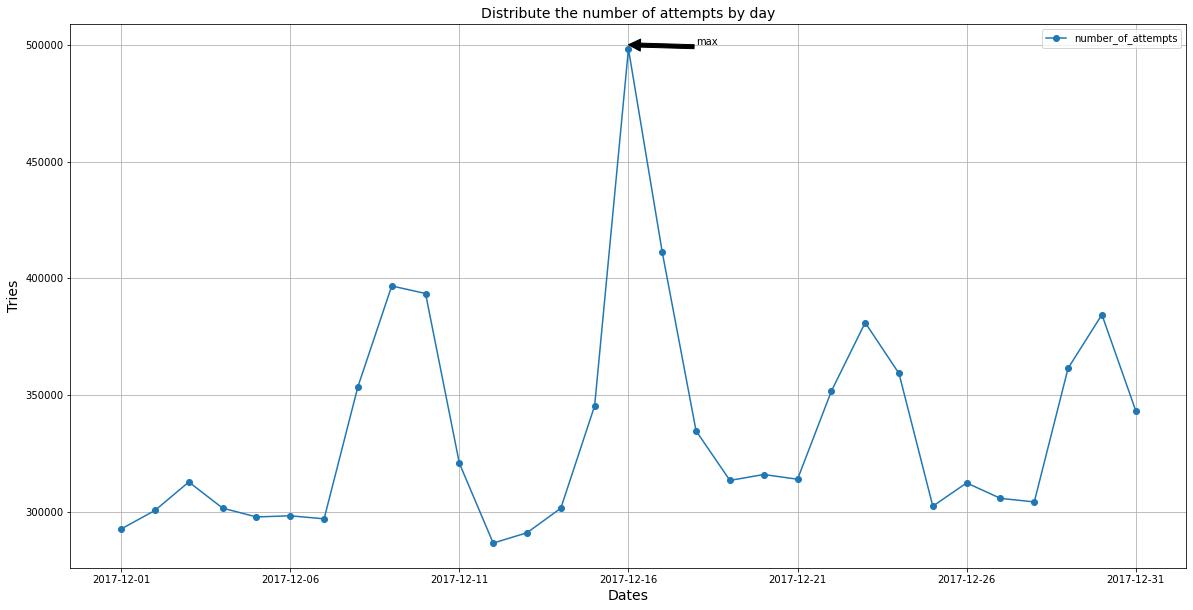

In [5]:
# I will create a table of data on user attempts to pass levels by day for the convenience of counting
attempts_dates = data['event_date'].value_counts().to_frame('number_of_attempts').rename_axis('date').sort_index()

# the graph
attempts_dates.plot(rot=0, figsize=(20, 10), grid=True, marker='o')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Distribute the number of attempts by day",fontsize=14)   
plt.ylabel('Tries', fontsize=14)   
plt.xlabel('Dates', fontsize=14) 
plt.legend() 
plt.annotate('max', xy=(15, 500000), xytext=(17, 500000), arrowprops=dict(facecolor='black'))
plt.show()

The graph of the total number of attempts by users to pass levels by day shows bursts of activity in the second half of the week (Friday, Saturday, Sunday), as well as residual activity can be traced on Mondays. The greatest activity is observed on Saturdays.

Graph #2: Unique players by day

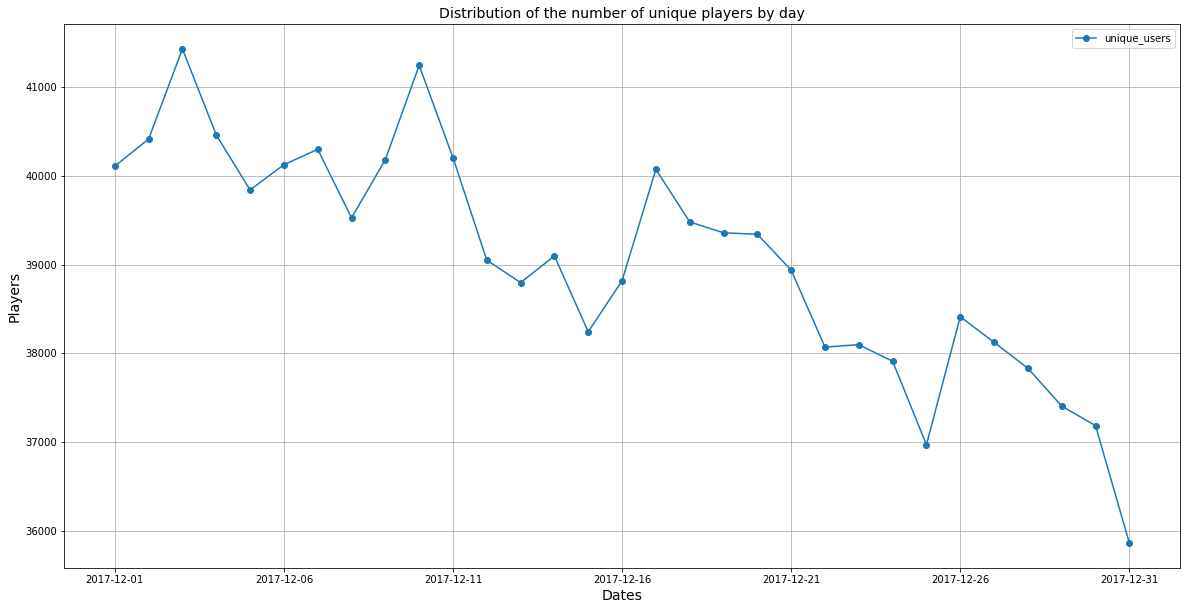

In [6]:
# table
attempts_dates_users = data.uid.groupby([data.event_date.str.strip("'")]).nunique().to_frame('unique_users')

# graph
attempts_dates_users.plot(rot=0, figsize=(20, 10), grid=True, marker='o')
plt.ticklabel_format(style='plain', axis='y')
plt.title("Distribution of the number of unique players by day",fontsize=14)   
plt.ylabel('Players', fontsize=14)   
plt.xlabel('Dates', fontsize=14) 
plt.legend() 
plt.show()

Plotting the distribution of unique players by day, you can see that the trend of the daily number of users (despite weekly fluctuations) tends to decrease.

1. Metrics describing the difficulty of levels: 

a) the success of passing the level by attempts. It shows the relationship between the success of passing the level and the number of attempts made to pass. 

It is calculated by dividing the number of unsuccessful attempts by the total number of attempts of players to complete the level.

b) You can also use an auxiliary metric: the success of passing the level by players, which also shows the relationship between the number of unique players who have passed the level and unique players trying to pass the level. 

It can be calculated by dividing the number of unique players who have passed the level by the total number of unique players trying to pass the level.

Metrics have a drawback: the fewer players made attempts to pass and pass the level, the less accurately we can say about the difficulty of the level. And, since the conversion rate of players is falling and falling with each level, it means that the higher the level, the less confidence we can say about the accuracy of determining the difficulty of the level.

a) the success of passing the level by attempts:

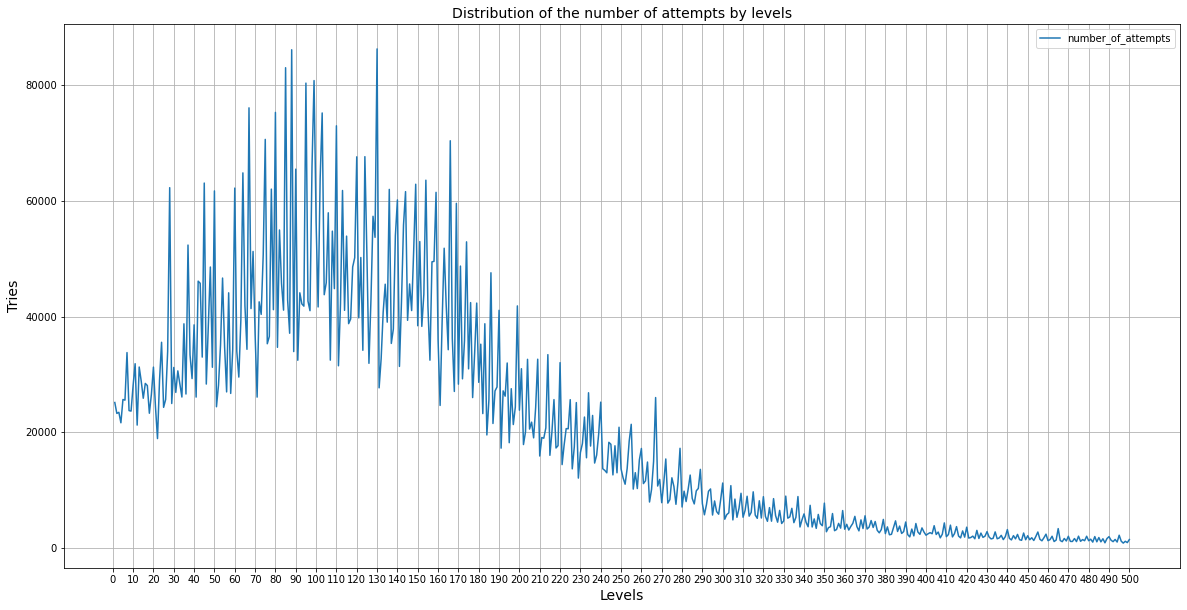

In [7]:
# table of attempts by levels
attempts_levels = data['level'].value_counts().to_frame('number_of_attempts').rename_axis('level').sort_index()

# the graph of attempts by levels is for verification
attempts_levels.plot(rot=0, figsize=(20, 10), grid=True)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Distribution of the number of attempts by levels",fontsize=14)   
plt.ylabel('Tries', fontsize=14)   
plt.xlabel('Levels', fontsize=14) 
plt.xticks(np.arange(0, 510, 10))
plt.legend() 
plt.show()

As can be seen from the graph, the maximum and minimum peaks are clearly traced systematically.

These highs and lows indirectly indicate the difficulty of the level. The more attempts - the more difficult the level.

Let 's calculate the proposed metric:

In [8]:
# column with unsuccessful attempts to pass
attempts_levels['failed_attempts'] = data['level'][data['action'].isin(['failed'])].value_counts().to_frame('failed_attempts')
# difficulty of levels by attempts
attempts_levels['hardness'] = ( attempts_levels['failed_attempts'] / attempts_levels['number_of_attempts'] ).round(2)
attempts_levels.describe()

,number_of_attempts,failed_attempts,hardness
count,500.000000,500.000000,500.00000
mean,20775.424000,13802.182000,0.62746
std,19785.013006,15012.292503,0.12338
min,779.000000,17.000000,0.00000
25%,3472.250000,2086.250000,0.55000
50%,14500.000000,7899.500000,0.63000
75%,33809.750000,21028.000000,0.72000
max,86321.000000,71808.000000,0.85000


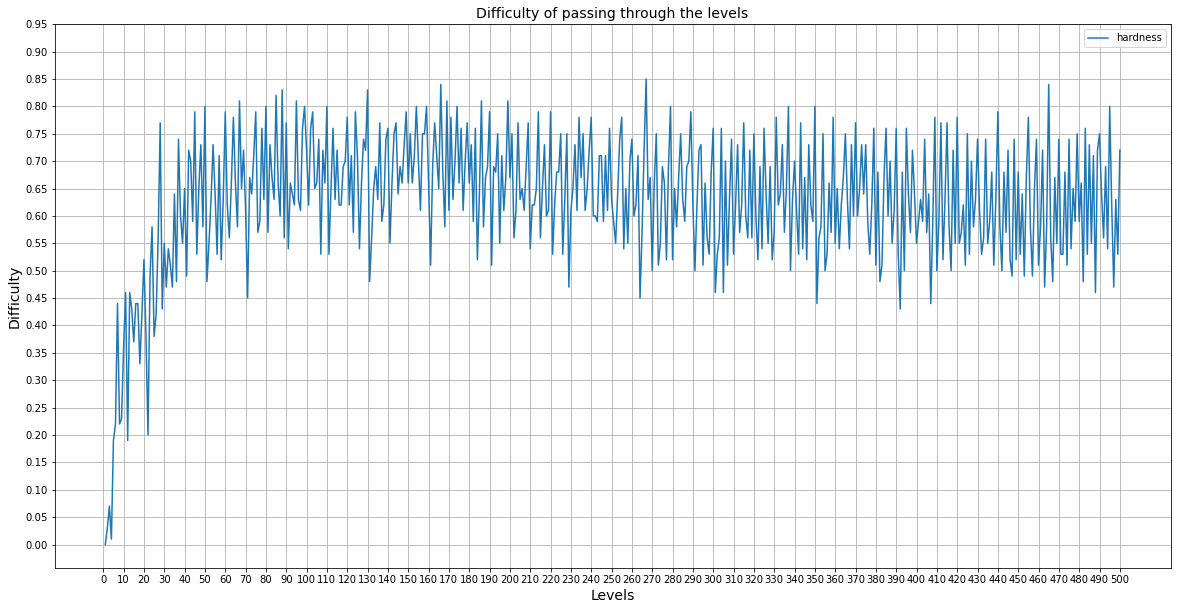

In [9]:
# graph with difficulty by levels
attempts_levels.plot(y = 'hardness', rot=0, figsize=(20, 10), grid=True)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Difficulty of passing through the levels",fontsize=14)   
plt.ylabel('Difficulty', fontsize=14)   
plt.xlabel('Levels', fontsize=14)
plt.yticks(np.arange(0, 1, 0.05))
plt.xticks(np.arange(0, 510, 10))
plt.grid(which='minor', linestyle=':')
plt.legend() 
plt.show()

The graph clearly shows an increase in the difficulty of the levels to +- 85 levels, then you can notice a trend for a slight decrease, which can be explained by a decrease in players, and, accordingly, attempts to pass the level.
The figure of the graph is a series of variations, frequent jumps indicate a constant change in the complexity of the levels (relative to the proposed metric.)
You can also see that the distribution of complexity by levels is systematic - approximately every 5-7 levels, the complexity varies from 10 to 30% more difficult / easier. 

The main trend is held at about 0.65

b) the success of passing the level by unique players:

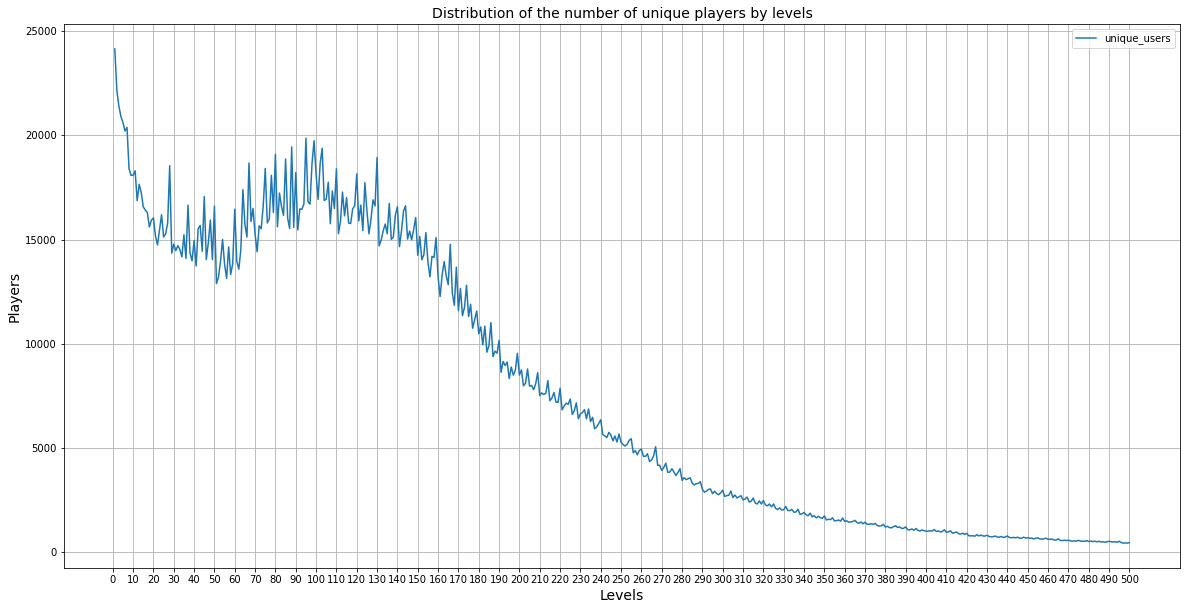

In [10]:
# a table with unique players at each level
attempts_levels_users = data.uid.groupby([data.level]).nunique().to_frame('unique_users')

# a graph with unique players by levels
attempts_levels_users.plot(rot=0, figsize=(20, 10), grid=True)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Distribution of the number of unique players by levels",fontsize=14)   
plt.ylabel('Players', fontsize=14)   
plt.xlabel('Levels', fontsize=14) 
plt.xticks(np.arange(0, 510, 10))
plt.legend() 
plt.show()

In [11]:
# successfully completed players
attempts_levels_users['success'] = data.uid[data['action'].isin(['completed'])].groupby([data.level]).nunique().to_frame('unique_users')
# percentage of players who successfully completed the level
attempts_levels_users['users_pass'] = ( attempts_levels_users['success'] / attempts_levels_users['unique_users'] ).round(2)
attempts_levels_users.describe()

,unique_users,success,users_pass
count,500.000000,500.000000,500.000000
mean,7607.716000,6816.842000,0.916340
std,6636.324578,5883.389762,0.052021
min,407.000000,386.000000,0.740000
25%,1308.500000,1201.250000,0.890000
50%,5293.000000,4885.500000,0.930000
75%,14772.500000,13066.500000,0.960000
max,24162.000000,24157.000000,1.000000


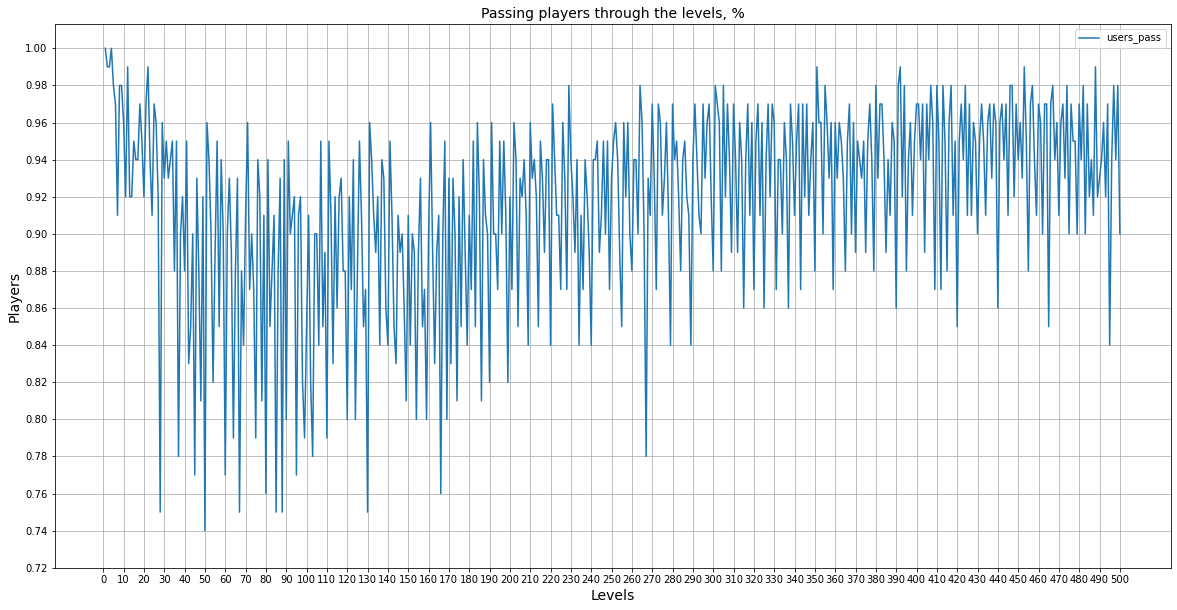

In [12]:
# graph with difficulty by player
attempts_levels_users.plot(y = 'users_pass', rot=0, figsize=(20, 10), grid=True)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Passing players through the levels, %",fontsize=14)   
plt.ylabel('Players', fontsize=14)   
plt.xlabel('Levels', fontsize=14) 
plt.yticks(np.arange(0.72, 1, 0.02))
plt.xticks(np.arange(0, 510, 10))
plt.grid(which='minor', linestyle=':')
plt.legend() 
plt.show()

The lower peaks show that approximately every 10th level causes difficulties for players, because the percentage of players passed is significantly reduced.

2. According to the calculated metrics, it becomes possible to divide the levels by complexity:

It can be concluded from the graphs that peaks can be considered "difficult" levels, after which there is a strong decline in the number of attempts to pass.

In terms of difficulty by levels (a), as can be seen from the graph, the first 30 levels are very easy. The value after which the difficulty increases is approximately 0.50 - this difficulty value can be taken as the minimum threshold for determining the level as "easy".

The lower peaks after level 40 show the average difficulty of "medium" damage, starting from 0.50 and, approximately, up to 0.70, which indicates a 30% success rate of passing the level.

The upper peaks show a high difficulty of passing, which is observed at levels with values from 0.70 to 0.8 shows a high difficulty.

Values of more than 0.8 are extremely rare, which indicates the maximum complexity of the level according to this metric, this value can be taken as "extreme"

In [13]:
attempts_levels['level_of_hard'] = np.where(attempts_levels.hardness < 0.5 , 'low', 
                                    np.where((attempts_levels.hardness >= 0.5) & (attempts_levels.hardness < 0.7), 'medium',
                                    np.where((attempts_levels.hardness >= 0.7) & (attempts_levels.hardness < 0.8), 'high', 'extreme')))
attempts_levels.describe()

,number_of_attempts,failed_attempts,hardness
count,500.000000,500.000000,500.00000
mean,20775.424000,13802.182000,0.62746
std,19785.013006,15012.292503,0.12338
min,779.000000,17.000000,0.00000
25%,3472.250000,2086.250000,0.55000
50%,14500.000000,7899.500000,0.63000
75%,33809.750000,21028.000000,0.72000
max,86321.000000,71808.000000,0.85000


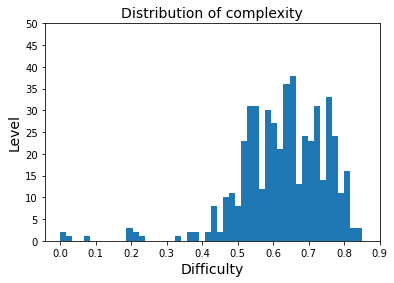

In [14]:
# hardness distribution graph
plt.hist(attempts_levels['hardness'], bins = 50, histtype='bar')   
plt.xlabel('Difficulty', fontsize=14)   
plt.ylabel('Level', fontsize=14)   
plt.yticks(np.arange(0, 55, 5))
plt.xticks(np.arange(0, 1, 0.1))
plt.title('Distribution of complexity', fontsize=14)
plt.show()

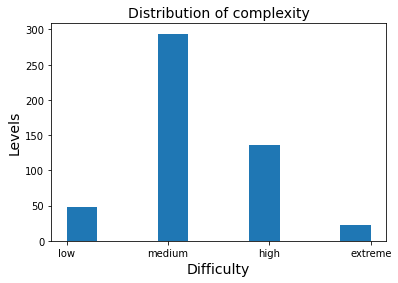

In [15]:
# distribution graph of level_of_hard
plt.hist(attempts_levels['level_of_hard'], histtype='bar', rwidth=1)   
plt.xlabel('Difficulty', fontsize=14)   
plt.ylabel('Levels', fontsize=14)   
plt.title('Distribution of complexity', fontsize=14)
plt.show()

According to the distribution, it can be seen that most levels have a "medium" complexity in the range from 0.5 to 0.7 according to the selected metric

According to the complexity of the players (b), as can be seen from the graph, the first 30 levels are also very easy, the percentage of players passed further is up to 90% of the players. The value after which the difficulty increases is approximately 0.98 - this difficulty value can be taken as the minimum threshold for determining the level as "Easy" to pass.

The upper peaks after level 20 show the average difficulty of the levels, starting from 0.98 and, approximately, up to 0.84, which indicates an 84% success rate of passing the level.

The lower peaks show a high difficulty of passing, which is observed at levels with values from 0.90 to 0.94 shows a low difficulty.

Values of 0.74-0.76 are extremely rare, which indicates the maximum complexity of the level according to this metric, this value can be taken as "extreme"

In [16]:
attempts_levels_users['hardness'] = np.where(attempts_levels_users.users_pass > 0.98 , 'Easy', 
                                    np.where((attempts_levels_users.users_pass <= 0.98) & (attempts_levels_users.users_pass > 0.84), 'Medium',
                                    np.where((attempts_levels_users.users_pass <= 0.84) & (attempts_levels_users.users_pass > 0.76), 'High', 'Extrem')))
attempts_levels_users.describe()

,unique_users,success,users_pass
count,500.000000,500.000000,500.000000
mean,7607.716000,6816.842000,0.916340
std,6636.324578,5883.389762,0.052021
min,407.000000,386.000000,0.740000
25%,1308.500000,1201.250000,0.890000
50%,5293.000000,4885.500000,0.930000
75%,14772.500000,13066.500000,0.960000
max,24162.000000,24157.000000,1.000000


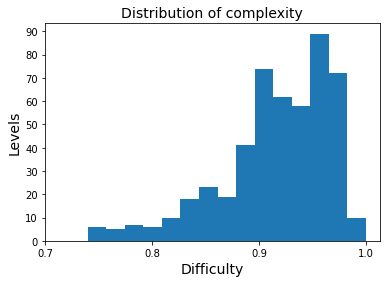

In [17]:
# users_pass distribution graph
plt.hist(attempts_levels_users['users_pass'], bins = 15, histtype='bar')   
plt.xlabel('Difficulty', fontsize=14)   
plt.ylabel('Levels', fontsize=14)   
plt.yticks(np.arange(0, 100, 10))
plt.xticks(np.arange(0.7, 1, 0.1))
plt.title('Distribution of complexity', fontsize=14)
plt.show()

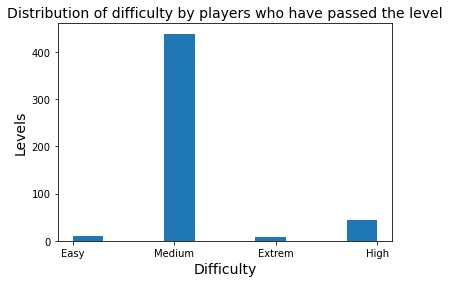

In [18]:
# distribution graph
plt.hist(attempts_levels_users['hardness'], histtype='bar', rwidth=1)   
plt.xlabel('Difficulty', fontsize=14)   
plt.ylabel('Levels', fontsize=14)   
plt.title('Distribution of difficulty by players who have passed the level', fontsize=14)   
plt.show()

Similar to the previous graph, this bar chart also shows that most of the levels have average difficulty, and most of the levels have difficulty in the range from 0.9 to 0.98 according to the chosen metric.

3. The "funnel" of passing levels by a new user after installing the game implies cutting off from the data of all players who do not have the passage of level 1 for the available period and calculating the number of unique new players by levels.

Generally speaking, the total conversion (for all players, regardless of the time of the game and the level passed) from 1 to 500 levels for unique users for the selected period is 1.78%.

In [19]:
users_500 = data['uid'][data['level'].isin([500])].nunique()
users_1 = data['uid'][data['level'].isin([1])].nunique()
general_conversion = round ( (users_500 / users_1 * 100)  ,2)
print("The number of unique players who have reached level 500:", users_500 )
print("The number of unique players who have passed level 1:", users_1 )
print("Total conversion from 1 to 500 level of unique players:" ,general_conversion  , "%")

The number of unique players who have reached level 500: 429
The number of unique players who have passed level 1: 24162
Total conversion from 1 to 500 level of unique players: 1.78 %


Let's calculate the number of unique users for the entire period: 196088 players, 24162 (12.32%) of them are new (passed level 1).

In [20]:
unique_new_users = data['uid'][data['level'].isin([1])].nunique()
unique_users = data['uid'].nunique()
new_users_percentage = round ( (unique_new_users / unique_users * 100) ,2)
print("Number of new unique players:", unique_new_users )
print("Number of unique players:", unique_users )
print("Percentage of new players:" , new_users_percentage , "%")

Number of new unique players: 24162
Number of unique players: 196088
Percentage of new players: 12.32 %


In order to build the required funnel, you need to count for each level the number of users who had an attempt at level 1.
To do this, you need to create a list of users who have passed level 1.

In [21]:
# Selection of unique players who played level 1
new_users_ndarray = data['uid'][data['level'] == 1].unique()
# filtering the main table by new players
data_new_users = data.loc[data['uid'].isin(new_users_ndarray)]
# counting the number of new players for each level
unique_new_users = data_new_users.groupby('level').uid.nunique().to_frame('new_users')

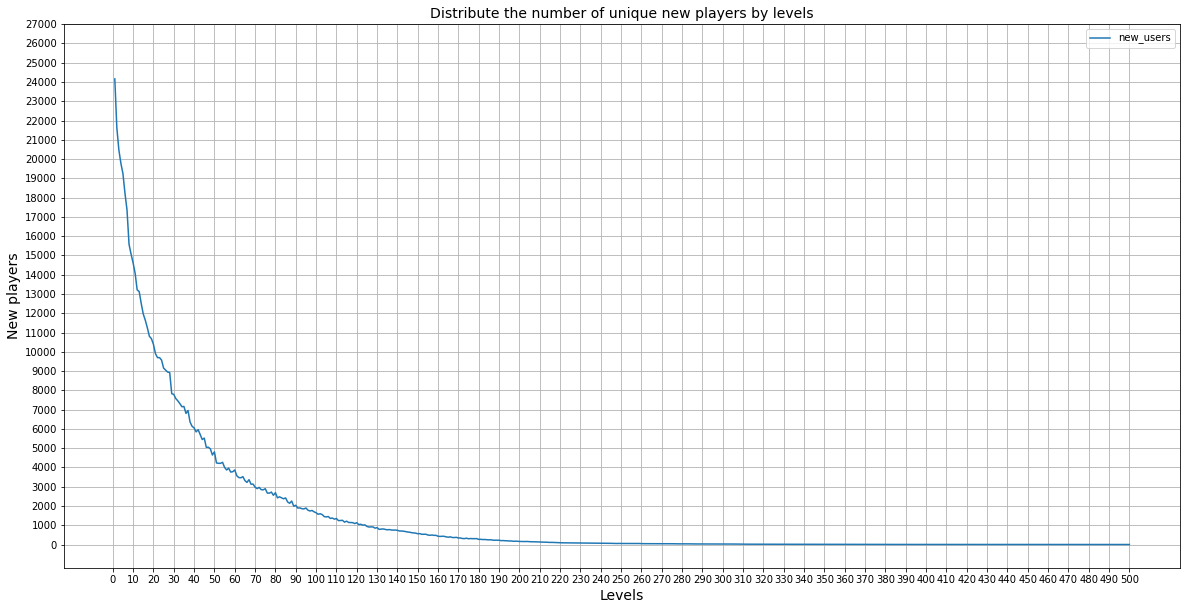

In [22]:
# graph "funnel" of new users
unique_new_users.plot(y = 'new_users', rot=0, figsize=(20, 10), grid=True)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Distribute the number of unique new players by levels",fontsize=14)   
plt.ylabel('New players', fontsize=14)   
plt.xlabel('Levels', fontsize=14) 
plt.yticks(np.arange(0, 28000, 1000))
plt.xticks(np.arange(0, 510, 10))
plt.legend() 
plt.show()

The graph took the form of an exponential function with a close approximation to 0 already at a value of about 200.

As can be seen from the graph, not every new player will pass beyond level 200, after which there is a plateau approaching zero.

A sharp decline is observed almost immediately: almost half of the players do not reach level 15, and only 25% of new players reach level 40. 10% of players barely reach level 80.

Comment on the completion of the test task:

• approximate estimate of the time you spent on the task: about 24 working hours (4 days)

• comments on the generated metric (p1): why this metric will be indicative: The goal was to describe the complexity of the levels, respectively, the more complex the level is programmed, the more time / attempts players need to spend on solving the level and fewer players will be able/willing to try to pass it in principle. Therefore, the ratio of failed attempts to all will be an indicator of the difficulty of each level.

